In [48]:
import scipy.sparse
from sklearn.preprocessing import StandardScaler
import warnings
import pandas as pd
import numpy as np
from sklearn.naive_bayes import BernoulliNB
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import scikitplot.metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
import sqlite3
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# newData.sqlite contains the preprocessed Data

# BAG OF WORDS

In [49]:
conn=sqlite3.connect(r'''C:\Users\akash\ML\AMAZON/newData.sqlite''')
data=pd.read_sql_query("SELECT * FROM Reviews",conn)

sortedData=data.sort_values(by=["Time"],axis=0)

Data=sortedData.head(100000)

D=Data.iloc[:,[11,7,9]]

train, validate, test = np.split(D.sample(frac=1), [int(.6*len(D)), int(.8*len(D))])

xTrain=train["cleanedText"]
labelsTrain=train["Score"]
xcv=validate["cleanedText"]
labelsCv=validate["Score"]
xtest=test["cleanedText"]
labelsTest=test["Score"]

model0=CountVectorizer(ngram_range=(1,4),min_df=10)
model0.fit(xTrain)
sparseBOWTrain=model0.transform(xTrain)
sparseBOWCv=model0.transform(xcv)
sparseBOWTest=model0.transform(xtest)

In [50]:
print(sparseBOWTrain.shape)
print(sparseBOWCv.shape)
print(sparseBOWTest.shape)

(60000, 35611)
(20000, 35611)
(20000, 35611)


In [51]:
featuresBOW=model0.get_feature_names()
print("total features for cleanedData are : ")
print(len(featuresBOW))

total features for cleanedData are : 
35611


## converting positive,negative to 0,1

In [52]:
lstTrain=[]
for col in labelsTrain.values:
    if(col=="positive"):
        lstTrain.append(1)
    else:
        lstTrain.append(0)
print(len(lstTrain))

60000


In [53]:
lstcv=[]
for col in labelsCv.values:
    if(col=="positive"):
        lstcv.append(1)
    else:
        lstcv.append(0)
print(len(lstcv))

20000


In [54]:
lsttest=[]
for col in labelsTest.values:
    if(col=="positive"):
        lsttest.append(1)
    else:
        lsttest.append(0)
print(len(lsttest))

20000


## calculating length of every review

In [55]:
lenxTrain=[]
for value in xTrain.values:
    lenxTrain.append(len(value))
lenxcv=[]
for value in xcv.values:
    lenxcv.append(len(value))
lenxTest=[]
for value in xtest.values:
    lenxTest.append(len(value))

## taking the summary data too into consideration for building model

In [56]:
sumTrain=train["Summary"]
sumcv=validate["Summary"]
sumTest=test["Summary"]

## building the model for summary

In [116]:
model=CountVectorizer(ngram_range=(1,3),min_df=10)
model.fit(sumTrain)
sparseBOWTrainSUMM=model.transform(sumTrain)
sparseBOWCvSUMM=model.transform(sumcv)
sparseBOWTestSUMM=model.transform(sumTest)

## getting features of summary data

In [117]:
featuresSummary=model.get_feature_names()

In [118]:
print("total no. of features of summary data are: ")
print(len(featuresSummary))

total no. of features of summary data are: 
4664


## concat. sparse matrices of cleanedData and Summary Data

In [119]:
from scipy.sparse import hstack
mergedTrain=hstack((sparseBOWTrain, sparseBOWTrainSUMM))
mergedcv=hstack((sparseBOWCv,sparseBOWCvSUMM))
mergedTest=hstack((sparseBOWTest,sparseBOWTestSUMM))

In [120]:
mergedTrain.shape

(60000, 40275)

## concat. length of reviews  as well

In [121]:
X_train_dtm = hstack((mergedTrain,np.array(lenxTrain)[:,None]))
X_cv_dtm = hstack((mergedcv,np.array(lenxcv)[:,None]))
X_test_dtm=hstack((mergedTest,np.array(lenxTest)[:,None]))

In [122]:
print("new sparse matrix with added summary and length of reviews")
print(X_train_dtm.shape)

new sparse matrix with added summary and length of reviews
(60000, 40276)


## calculating the best alpha value for the final model 

In [124]:
x=[0.0001,0.001,0.01,0.1,1,10,100,1000]

## here we are using MultinomialNB for BOW model because multinomialNB is good for discrete features like word count in text classification data

In [125]:
scoresRecallTrain=[]
scoresRecallcv=[]
scorespreTrain=[]
scoresprecv=[]
scoresf1Train=[]
scoresf1cv=[]
for alpha in tqdm(x):
    clf=MultinomialNB(alpha)
    clf.fit(X_train_dtm,lstTrain)
    predTrain=clf.predict(X_train_dtm)
    predcv=clf.predict(X_cv_dtm)
    scoresRecallTrain.append(accuracy_score(lstTrain,predTrain))
    scoresRecallcv.append(accuracy_score(lstcv,predcv))
    scorespreTrain.append(precision_score(lstTrain,predTrain,average="weighted"))
    scoresprecv.append(precision_score(lstcv,predcv,average="weighted"))
    scoresf1Train.append(f1_score(lstTrain,predTrain,average="weighted"))
    scoresf1cv.append(f1_score(lstcv,predcv,average="weighted"))
    

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.26it/s]


In [126]:
#ERROR
MSERecalltrain=[1-x for x in scoresRecallcv]

MSERecallcv=[1-x for x in scoresRecallcv]
bestAlphaRecall=x[MSERecallcv.index(min(MSERecallcv))]

MSEpretrain=[1-x for x in scorespreTrain]

MSEprecv=[1-x for x in scoresprecv]
bestAlphapre=x[MSEprecv.index(min(MSEprecv))]

MSEf1train=[1-x for x in scoresf1Train]

MSEf1cv=[1-x for x in scoresf1cv]
bestAlphaf1=x[MSEf1cv.index(min(MSEf1cv))]

In [127]:
print("optimal alpha is for recall as a metrics is {}".format(bestAlphaRecall))
print("optimal alpha is for pre as a metrics is {}".format(bestAlphapre))
print("optimal alpha is for f1 as a metrics is {}".format(bestAlphaf1))

optimal alpha is for recall as a metrics is 0.001
optimal alpha is for pre as a metrics is 1
optimal alpha is for f1 as a metrics is 0.01


## plotting the training error

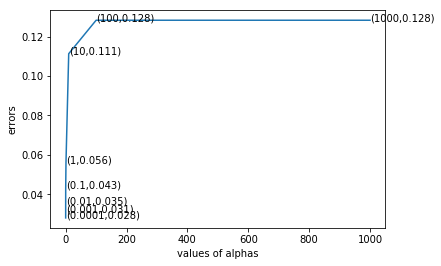

In [99]:
#using pre as metrics
plt.plot(x,MSEpretrain)
for xy in zip(x,np.round(MSEpretrain,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

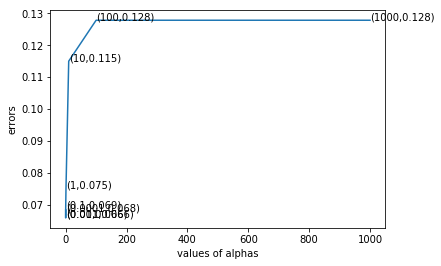

In [100]:
#using recall as  metrics
plt.plot(x,MSERecalltrain)
for xy in zip(x,np.round(MSERecalltrain,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

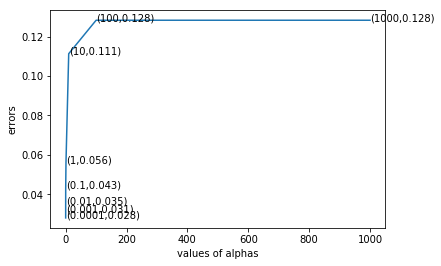

In [101]:
#using f1score metrics
plt.plot(x,MSEf1train)
for xy in zip(x,np.round(MSEf1train,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

## plotting cv error

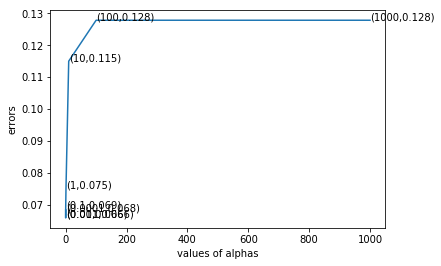

In [102]:
#using pre as metrics
plt.plot(x,MSEprecv)
for xy in zip(x,np.round(MSEprecv,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

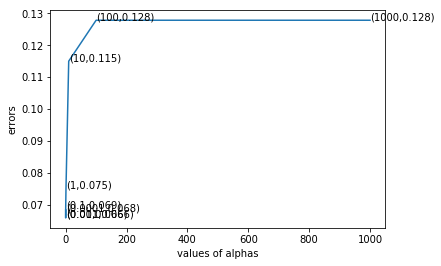

In [103]:
#using recall as metrics
plt.plot(x,MSERecallcv)
for xy in zip(x,np.round(MSERecallcv,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

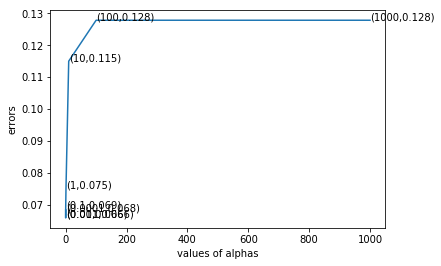

In [104]:
#using f1score as metrics
plt.plot(x,MSEf1cv)
for xy in zip(x,np.round(MSEf1cv,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

## confusion metrics for train data

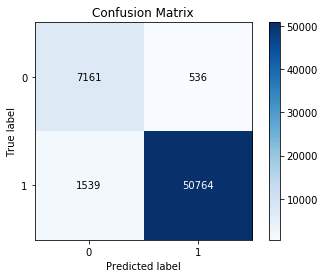

In [133]:
clf=MultinomialNB(bestAlphaf1)
clf.fit(X_train_dtm,lstTrain)
pred=clf.predict(X_train_dtm)
scikitplot.metrics.plot_confusion_matrix(lstTrain,pred)

## observation:
using f1 score as a metric is giving the best results.


## confusion metrics for test data

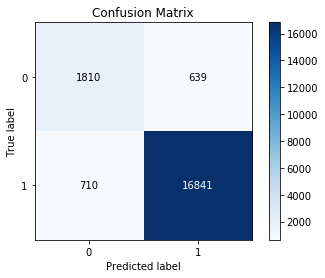

In [136]:
clf=MultinomialNB(bestAlphaf1)
clf.fit(X_train_dtm,lstTrain)
pred=clf.predict(X_test_dtm)
scikitplot.metrics.plot_confusion_matrix(lsttest,pred)

## observation:
model is able to predict 74 % of the negative points and 95 % of the positive points.

f1 score is used as metrics



In [137]:
ll=clf.feature_log_prob_
print(ll.shape)

result=featuresBOW + featuresSummary
le=["reviewLENGTH"]
result+=le
print(len(result))

## BULDING THE DATAFRAME
df=pd.DataFrame(ll,columns=result)

(2, 40276)
40276


## top  negative features

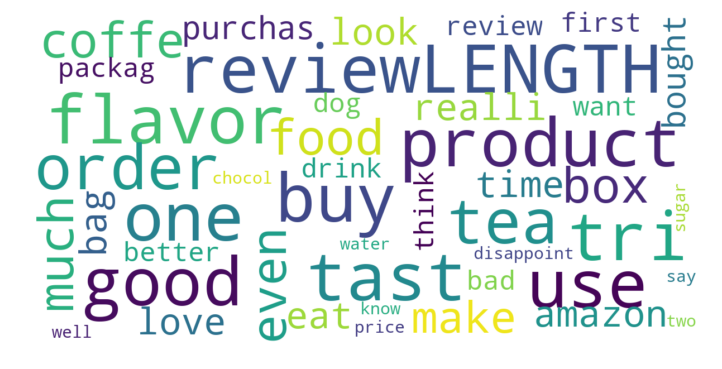

In [138]:
neg=df.iloc[0,:].sort_values(ascending=False)[0:50]
neg=neg.keys()
#wordcloud = WordCloud().generate(neg)
wordcloud2 = WordCloud( background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(neg))
# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## top positive features

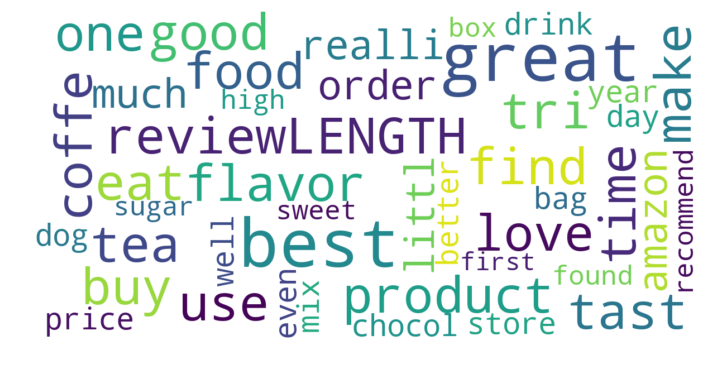

In [141]:
pos=df.iloc[1,:].sort_values(ascending=False)[0:50]
pos=pos.keys()
wordcloud2 = WordCloud( background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(pos))
# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

# TFIDF

In [143]:
model=TfidfVectorizer(ngram_range=(1,4),min_df=10)
model.fit(xTrain)
sparseTFIDFTrain=model.transform(xTrain)
sparseTFIDFCv=model.transform(xcv)
sparseTFIDFTest=model.transform(xtest)

In [144]:
featuresTFIDF=model.get_feature_names()
print("total features for cleanedData are : ")
print(len(featuresTFIDF))

total features for cleanedData are : 
35611


## Taking the summary data as well as length for building the model

In [145]:
model=TfidfVectorizer(ngram_range=(1,2),min_df=10)
model.fit(sumTrain)
sparseTFIDFTrainSUMM=model.transform(sumTrain)
sparseTFIDFCvSUMM=model.transform(sumcv)
sparseTFIDFTestSUMM=model.transform(sumTest)

## features of summary data

In [146]:
featuresSummary=model.get_feature_names()

## concatenating sparse data of cleanedData and summary data

In [148]:
mergedTrain=hstack((sparseTFIDFTrain, sparseTFIDFTrainSUMM))
mergedcv=hstack((sparseTFIDFCv,sparseTFIDFCvSUMM))
mergedTest=hstack((sparseTFIDFTest,sparseTFIDFTestSUMM))

## concat. length also

In [149]:
X_train_dtm = hstack((mergedTrain,np.array(lenxTrain)[:,None]))
X_cv_dtm = hstack((mergedcv,np.array(lenxcv)[:,None]))
X_test_dtm=hstack((mergedTest,np.array(lenxTest)[:,None]))

# here we are using MultinomialNB for TFIDF model because multinomialNB is good for discrete features like word count in text classification data

In [150]:
scoresRecallTrain=[]
scoresRecallcv=[]
scorespreTrain=[]
scoresprecv=[]
scoresf1Train=[]
scoresf1cv=[]
for alpha in tqdm(x):
    clf=MultinomialNB(alpha)
    clf.fit(X_train_dtm,lstTrain)
    predTrain=clf.predict(X_train_dtm)
    predcv=clf.predict(X_cv_dtm)
    scoresRecallTrain.append(accuracy_score(lstTrain,predTrain))
    scoresRecallcv.append(accuracy_score(lstcv,predcv))
    scorespreTrain.append(precision_score(lstTrain,predTrain,average="weighted"))
    scoresprecv.append(precision_score(lstcv,predcv,average="weighted"))
    scoresf1Train.append(f1_score(lstTrain,predTrain,average="weighted"))
    scoresf1cv.append(f1_score(lstcv,predcv,average="weighted"))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.03it/s]


In [152]:
#ERROR
MSERecalltrain=[1-x for x in scoresRecallcv]

MSERecallcv=[1-x for x in scoresRecallcv]
bestAlphaRecall=x[MSERecallcv.index(min(MSERecallcv))]

MSEpretrain=[1-x for x in scorespreTrain]

MSEprecv=[1-x for x in scoresprecv]
bestAlphapre=x[MSEprecv.index(min(MSEprecv))]

MSEf1train=[1-x for x in scoresf1Train]

MSEf1cv=[1-x for x in scoresf1cv]
bestAlphaf1=x[MSEf1cv.index(min(MSEf1cv))]

In [153]:
print("optimal alpha for recall as a metrics is {}".format(bestAlphaRecall))
print("optimal alpha for pre as a metrics is {}".format(bestAlphapre))
print("optimal alpha for f1 as a metrics is {}".format(bestAlphaf1))

optimal alpha for recall as a metrics is 0.1
optimal alpha for pre as a metrics is 0.1
optimal alpha for f1 as a metrics is 0.1


## plotting the training error

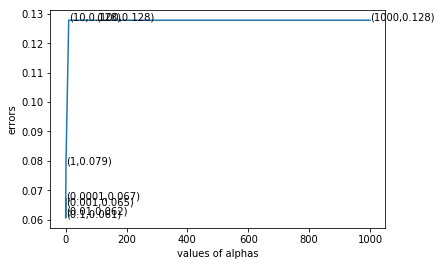

In [154]:
#using accuracy as  metrics
plt.plot(x,MSERecalltrain)
for xy in zip(x,np.round(MSERecalltrain,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

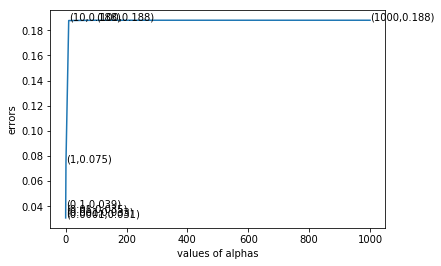

In [155]:
#using f1score metrics
plt.plot(x,MSEf1train)
for xy in zip(x,np.round(MSEf1train,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

## plotting cv error

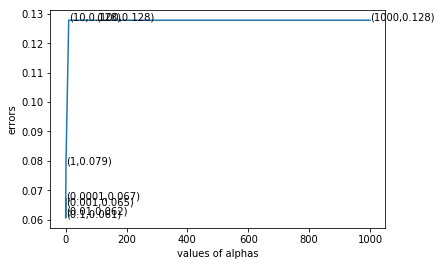

In [156]:
#using accuracy as metrics
plt.plot(x,MSERecallcv)
for xy in zip(x,np.round(MSERecallcv,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

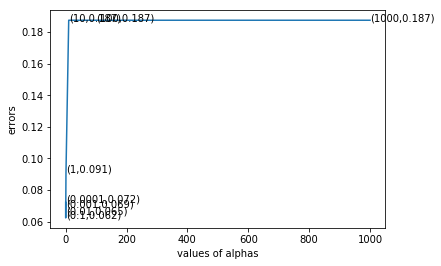

In [157]:
#using f1score as metrics
plt.plot(x,MSEf1cv)
for xy in zip(x,np.round(MSEf1cv,3)):
    plt.annotate("(%s,%s)" % xy,xy=xy)
plt.xlabel("values of alphas")
plt.ylabel("errors")
plt.show()

## confusion metrics for train data

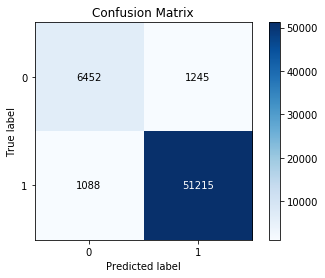

In [158]:
clf=MultinomialNB(bestAlphaf1)
clf.fit(X_train_dtm,lstTrain)
pred=clf.predict(X_train_dtm )
scikitplot.metrics.plot_confusion_matrix(lstTrain,pred)

## observation:
for the training data we are able to predict 83 % of the negative points and 97 % of the positive points

## confusion metric for test data

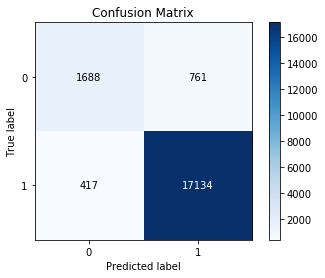

In [159]:
clf=MultinomialNB(bestAlphaf1)
clf.fit(X_train_dtm ,lstTrain)
pred=clf.predict(X_test_dtm)
scikitplot.metrics.plot_confusion_matrix(lsttest,pred)

## observation:
for this model we can predict 68 % of the negative points and 97 % of the positive points

In [153]:
ll=clf.feature_log_prob_
print(ll.shape)

result=featuresTFIDF + featuresSummary
le=["reviewLENGTH"]
result+=le
print(len(result))

## BULDING THE DATAFRAME
df=pd.DataFrame(ll,columns=result)

(2, 905370)
905370


## top  negative features

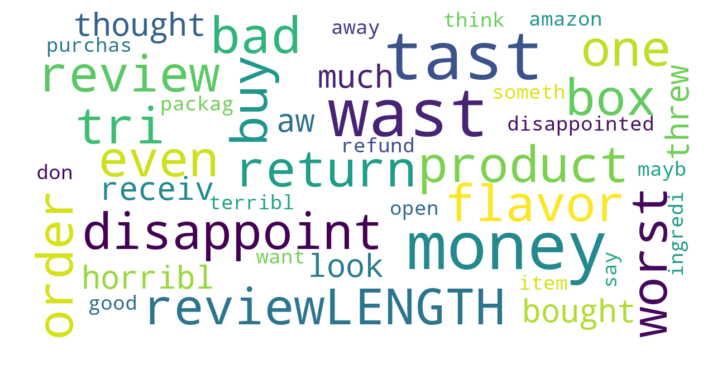

In [154]:
neg=df.iloc[0,:].sort_values(ascending=False)[0:50]
neg=neg.keys()
#wordcloud = WordCloud().generate(neg)
wordcloud2 = WordCloud( background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(neg))
# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## top positive features

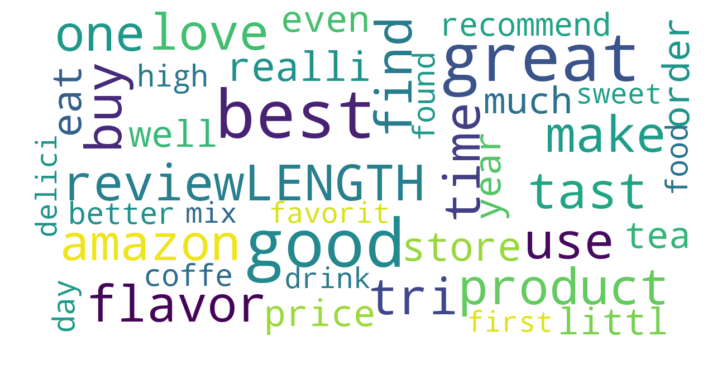

In [155]:
pos=df.iloc[1,:].sort_values(ascending=False)[0:50]
pos=pos.keys()
wordcloud2 = WordCloud( background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(pos))
# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["vectorizer", "metrics", "hyperparameter"]

x.add_row(["BOW", "precision_score",1])
x.add_row(["BOW", "accuracy_score", 0.001])
x.add_row(["BOW","f1_score", 0.01])
x.add_row(["TFIDF","precision_score", 0.1])
x.add_row(["TFIDF", "accuracy_score", 0.1])
x.add_row(["TFIDF","f1_score",0.1])
print(x)

+------------+-----------------+----------------+
| vectorizer |     metrics     | hyperparameter |
+------------+-----------------+----------------+
|    BOW     | precision_score |       1        |
|    BOW     |  accuracy_score |     0.001      |
|    BOW     |     f1_score    |      0.01      |
|   TFIDF    | precision_score |      0.1       |
|   TFIDF    |  accuracy_score |      0.1       |
|   TFIDF    |     f1_score    |      0.1       |
+------------+-----------------+----------------+
